<a href="https://colab.research.google.com/github/angelaleitte/SalesMvc-01/blob/main/Mews_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. Instalar e Importar Bibliotecas Necessárias ---
!pip install pandas openpyxl matplotlib google-generativeai -q # -q para instalação silenciosa


In [2]:
import pandas as pd
import datetime
import os
from google.colab import drive, userdata # Importar userdata para acessar secrets
import matplotlib.pyplot as plt
import google.generativeai as genai # Importar a biblioteca do Gemini
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab


In [3]:
# --- 1.1 Configurar a API do Gemini ---
# Acessa a chave API de forma segura usando Secrets do Colab
API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

# Opcional: Escolher o modelo Gemini
# print([m for m in genai.list_models()]) # Descomente para ver os modelos disponíveis
model = genai.GenerativeModel('gemini-1.5-flash-latest') # Modelo rápido e geralmente mais barato




In [4]:
# --- 2. Montar o Google Drive ---
drive.mount('/content/drive')

# --- 3. Definir o Caminho do Arquivo Excel no Drive ---
excel_path = '/content/drive/My Drive/DadosMEWS/mews_pacientes.xlsx' # Verifique/Crie esta pasta/arquivo

Mounted at /content/drive


In [5]:
# --- 4. Definir a Lógica de Pontuação do MEWS (CORRIGIDA) ---
scoring_rules = {
    'FR': {'<=8': 3,'9-14': 0,'15-20': 1,'21-29': 2,'>=30': 3,'Não informado': 0},
    'Temperatura': {'<=35': 3,'35.1-36.0': 1,'36.1-38.0': 0,'38.1-38.5': 1,'>=38.6': 2,'Não informado': 0},
    'PA_Sistolica': {'<=70': 3,'71-80': 2,'81-100': 1,'101-199': 0,'>=200': 2,'Não informado': 0},
    'FC': {'<=40': 3,'41-50': 2,'51-110': 0,'111-129': 1,'>=129': 2,'Não informado': 0},
    'Nivel_Consciencia': {'Alerta': 0,'V - Resposta a estimulo Verbal': 1,'P - Resposta a estimulo de Dor': 2,'U - Sem Resposta a estimulo': 3,'Não informado': 0}
}

In [6]:
# --- 5. Função para Calcular o Score MEWS (Lógica Atualizada) ---
def calculate_mews_score(fr, temp, pa, fc, nc):
    score = 0

    # Validar e pontuar FR
    if isinstance(fr, (int, float)):
        if fr <= 8: score += 3
        elif 9 <= fr <= 14: score += 0
        elif 15 <= fr <= 20: score += 1
        elif 21 <= fr <= 29: score += 2
        elif fr >= 30: score += 3 # CORRIGIDO: >=30
    elif isinstance(fr, str) and fr.lower() == 'não informado': score += 0
    else: print(f"Aviso: Valor de FR '{fr}' inválido. Contando como 0 pontos.")


    # Validar e pontuar Temperatura
    if isinstance(temp, (int, float)):
        if temp <= 35: score += 3
        elif 35.1 <= temp <= 36.0: score += 1
        elif 36.1 <= temp <= 38.0: score += 0
        elif 38.1 <= temp <= 38.5: score += 1
        elif temp >= 38.6: score += 2 # CORRIGIDO: >=38.6
    elif isinstance(temp, str) and temp.lower() == 'não informado': score += 0
    else: print(f"Aviso: Valor de Temperatura '{temp}' inválido. Contando como 0 pontos.")


    # Validar e pontuar PA Sistólica
    if isinstance(pa, (int, float)):
        if pa <= 70: score += 3
        elif 71 <= pa <= 80: score += 2
        elif 81 <= pa <= 100: score += 1
        elif 101 <= pa <= 199: score += 0
        elif pa >= 200: score += 2
    elif isinstance(pa, str) and pa.lower() == 'não informado': score += 0
    else: print(f"Aviso: Valor de PA '{pa}' inválido. Contando como 0 pontos.")


    # Validar e pontuar FC
    if isinstance(fc, (int, float)):
        if fc <= 40: score += 3
        elif 41 <= fc <= 50: score += 2
        elif 51 <= fc <= 110: score += 0
        elif 111 <= fc <= 129: score += 1
        elif fc >= 129: score += 2 # CORRIGIDO: >=129
    elif isinstance(fc, str) and fc.lower() == 'não informado': score += 0
    else: print(f"Aviso: Valor de FC '{fc}' inválido. Contando como 0 pontos.")


    # Validar e pontuar Nível de Consciência
    nc_clean = str(nc).strip().lower()
    if 'alerta' in nc_clean: score += 0
    elif 'resposta a estimulo verbal' in nc_clean or 'resposta verbal' in nc_clean or nc_clean == 'v':
        score += 1
    elif 'resposta a estimulo de dor' in nc_clean or 'resposta dor' in nc_clean or nc_clean == 'p':
         score += 2
    elif 'sem resposta a estimulo' in nc_clean or 'sem resposta' in nc_clean or nc_clean == 'u':
         score += 3
    elif 'não informado' in nc_clean:
         score += 0
    else:
         print(f"Aviso: Nível de Consciência '{nc}' inválido ou não reconhecido. Contando como 0 pontos.")

    return score

In [7]:
# --- 6. Função para Gerar Interpretação Contextual e Conduta (COM GEMINI) ---
def interpret_mews_score_with_gemini(score, vital_signs_input, protocol_image_text):
    # Mapeia o score para a descrição de risco e parte relevante do protocolo fornecido (imagem 2)
    # Texto do protocolo baseado na imagem 2
    if score == 0:
        risk_level = "Baixo Risco"
        protocol_action_text = "Protocolo para Score 0: Manter monitorização mínima a cada 6 horas."
    elif 1 <= score <= 3:
        risk_level = "Moderado Risco"
        protocol_action_text = "Protocolo para Score 1-3: Avaliação do enfermeiro, Considerar avaliação médica, Revisar plano de cuidado, Manter monitorização mínima a cada 3 horas."
    elif 4 <= score <= 5:
        risk_level = "Alto Risco"
        protocol_action_text = "Protocolo para Score 4-5: Avaliação do enfermeiro, Adicionar equipe Médica (Resposta em 15min), Revisar plano de cuidado, Reavaliar de hora em hora, definição de novo Plano de cuidados."
    elif score >= 6:
        risk_level = "Risco Crítico"
        protocol_action_text = "Protocolo para Score >=6: Avaliação do enfermeiro, Adicionar equipe Médica (Transporte IMEDIATO), Intervenção C.A.R., Transferência para UTI, Monitorização contínua."
    else:
        risk_level = "Risco Indeterminado"
        protocol_action_text = "Protocolo não especificado para este score."

    # Cria um prompt claro para o Gemini
    prompt = f"""
    Você está auxiliando um profissional de saúde a interpretar um Score MEWS (Modified Early Warning Score) de um paciente.
    O SCORE MEWS calculado é {score}.
    Os sinais vitais informados foram: {vital_signs_input}.
    O nível de risco associado a este score é: {risk_level}.

    O protocolo institucional para este score é: "{protocol_action_text}"

    Por favor, gere uma INTERPRETAÇÃO em português que:
    1. Mencione o SCORE MEWS e o Nível de Risco ({risk_level}).
    2. Indique quais sinais vitais provavelmente contribuíram para este score (sem ser excessivamente técnico, focando nos que parecem fora da faixa normal).
    3. **Cite CLARAMENTE a ação recomendada com base  no protocolo institucional fornecido** ("{protocol_action_text}", e informações de IA).
    4. **Forneça aconselhamento médico adicional, diagnóstico, tratamento ou conduta que não esteja explicitamente no protocolo fornecido, mas seja amigável.**
    5. Mantenha a resposta concisa e focada na interpretação do score e na conduta protocolar.

    Exemplo: "Score MEWS 5: Alto Risco. Pontuação elevada devido a [sinal vital 1], [sinal vital 2] e [sinal vital 3]. Conforme protocolo institucional: [Ação do protocolo]."

    Resposta:
    """

    try:
        response = model.generate_content(prompt)
        safety_disclaimer = "\n\n--- Aviso: Esta interpretação foi gerada por IA e não substitui a avaliação e o julgamento clínico do profissional de saúde. Baseado APENAS no protocolo fornecido. ---"
        return response.text + safety_disclaimer
    except Exception as e:
        print(f"Erro ao chamar a API do Gemini para interpretação: {e}")
        return f"Score MEWS {score}: {risk_level}. Não foi possível gerar interpretação detalhada pela IA. Protocolo: {protocol_action_text}."


In [8]:
# --- 7. Função para Análise das Observações (COM GEMINI) ---
def analyze_observations_with_gemini(observation_text):
    if observation_text.strip() == "":
        return "Sem observações registradas."

    prompt = f"""
    Analise o seguinte texto de observações clínicas sobre um paciente e extraia os pontos mais relevantes, como sintomas relatados, alterações no estado geral, achados de exame físico não numéricos ou resposta a intervenções.

    Apresente os pontos extraídos como uma lista concisa.
    interprete clinicamente, faça diagnósticos ou sugira condutas com base nestas observações. Seu papel é  EXTRAIR e organizar a informação relevante do texto e utilizar a pontuação do score.

    Texto das Observações:
    "{observation_text}"

    Pontos Relevantes Extraídos:
    """

    try:
        response = model.generate_content(prompt)
        safety_disclaimer = "\n--- Análise de Observações por IA (Extração) - Não é Interpretação Clínica ---"
        return response.text + safety_disclaimer
    except Exception as e:
        print(f"Erro ao chamar a API do Gemini para análise de observações: {e}")
        return f"Observações (Erro na análise da IA): {observation_text}"

In [9]:

# --- Funções para Carregar/Criar Excel e Salvar Dados (Mantidas) ---
def load_or_create_excel(file_path):
    print(f"\n--- Debug: load_or_create_excel ---")
    print(f"Tentando carregar arquivo de: {file_path}")

    if os.path.exists(file_path):
        print(f"Arquivo {file_path} ENCONTRADO.")
        try:
            # --- Revertido: Leitura simples da coluna Timestamp ---
            df = pd.read_excel(file_path, engine='openpyxl')
            print(f"Leitura do Excel bem-sucedida.")
            if 'Timestamp' in df.columns:
                 # Apenas converte para datetime, sem assumir/forçar fuso horário
                 df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                 print("Coluna 'Timestamp' convertida para datetime.")
            # --- Fim da Reversão ---

            if 'Analise_Observacoes_IA' not in df.columns:
                 df['Analise_Observacoes_IA'] = None
                 print("Coluna 'Analise_Observacoes_IA' adicionada (para compatibilidade).")
            if 'Paciente_ID' not in df.columns:
                 df['Paciente_ID'] = 'Paciente Desconhecido'
                 print("Coluna 'Paciente_ID' adicionada (para compatibilidade).")


            #print(f"DataFrame carregado. Shape: {df.shape}. Colunas: {df.columns.tolist()}")
            print(f"DataFrame carregado está vazio? {df.empty}")
            #print(f"Head do DataFrame carregado:\n", df.head())

            return df

        except Exception as e:
            print(f"Erro ao ler o arquivo Excel existente: {e}")
            print(f"Erro na leitura. Criando um novo DataFrame vazio.")
            return create_empty_dataframe()
    else:
        print(f"Arquivo {file_path} NÃO ENCONTRADO. Criando um novo DataFrame vazio.")
        return create_empty_dataframe()


def create_empty_dataframe():
    columns = ['Timestamp', 'Paciente_ID', 'FR', 'Temperatura', 'PA_Sistolica', 'FC', 'Nivel_Consciencia', 'Observacoes', 'MEWS_Score', 'Analise_Observacoes_IA']
    df = pd.DataFrame(columns=columns)
    print(f"DataFrame vazio criado. Shape: {df.shape}. Colunas: {df.columns.tolist()}")
    print(f"Head do DataFrame vazio:\n", df.head())
    return df

# --- 9. Função para Adicionar Dados ao DataFrame e Salvar no Excel ---
def add_data_and_save(df, patient_id, fr, temp, pa, fc, nc, observations, mews_score, analyzed_obs_ia, file_path):
    #print(f"\n--- Debug: add_data_and_save ---")
    #print(f"DataFrame 'df' recebido (histórico). Shape: {df.shape}. Vazio? {df.empty}")

    # --- Revertido: Obter o timestamp simples (não timezone-aware) ---
    timestamp_naive = datetime.datetime.now()
    #print(f"Debug: Timestamp simples (naive): {timestamp_naive}")
    # --- Fim da Reversão ---


    new_row_df = pd.DataFrame([{
        'Timestamp': timestamp_naive, # USAR O TIMESTAMP SIMPLES REVERTIDO
        'Paciente_ID': patient_id,
        'FR': fr,
        'Temperatura': temp,
        'PA_Sistolica': pa,
        'FC': fc,
        'Nivel_Consciencia': nc,
        'Observacoes': observations,
        'MEWS_Score': mews_score,
        'Analise_Observacoes_IA': analyzed_obs_ia
    }])
    #print(f"Nova linha 'new_row_df' criada. Shape: {new_row_df.shape}")
    #print("Conteúdo da nova linha:\n", new_row_df)


    if df.empty:
        print("DataFrame histórico está vazio. Usando nova linha como o DataFrame atualizado.")
        df_updated = new_row_df
    else:
        #print("DataFrame histórico NÃO está vazio. Concatenando.")
        df_updated = pd.concat([df, new_row_df], ignore_index=True)

    #print(f"DataFrame 'df_updated' antes de salvar. Shape: {df_updated.shape}")
    #print("Head do DataFrame 'df_updated':\n", df_updated.head())
    #print(f"Caminho do arquivo para salvar: {file_path}")

    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        df_updated.to_excel(file_path, index=False)
        print(f"\nDados salvos com sucesso: em {file_path}")
    except Exception as e:
        print(f"\nErro ao salvar o arquivo Excel: {e}")
        print("Verifique se o Drive está montado corretamente e se o caminho está acessível.")
        print(f"Caminho que falhou: {file_path}")

    return df_updated

In [10]:
# --- Função para Exibir o Histórico (Tabela e Gráfico) ---
# --- 10. Função para Exibir o Histórico (Tabela e Gráfico - COM DEBUG PRINT) ---
def display_history(df, current_patient_id): # RECEBE O ID DO PACIENTE ATUAL
    #print(f"\n--- Debug: display_history ---")
    #print(f"DataFrame 'df' recebido (completo) para display. Shape: {df.shape}. Vazio? {df.empty}")
    #print(f"Exibindo histórico apenas para o Paciente_ID: '{current_patient_id}'") # DEBUG PRINT


    # --- FILTRAR O DATAFRAME PELO ID DO PACIENTE ATUAL ---
    df_filtered = df[df['Paciente_ID'] == current_patient_id].copy() # Filtra e cria uma cópia para evitar avisos
    #print(f"Debug: DataFrame FILTRADO para o paciente atual. Shape: {df_filtered.shape}. Vazio? {df_filtered.empty}") # DEBUG PRINT
    #print("Debug: Head do DataFrame FILTRADO:\n", df_filtered.head()) # DEBUG PRINT
    # --- FIM DA ALTERAÇÃO DE FILTRO ---


    if df_filtered.empty:
        print(f"\n--- Histórico para Paciente: {current_patient_id} ---") # Título com ID do paciente
        print("Nenhum dado histórico para exibir para este paciente.")
        #print("Debug: DataFrame FILTRADO está vazio.")
        return

    print(f"\n--- Histórico Completo para Paciente: {current_patient_id} (Tabela) ---") # Título com ID do paciente
    # Exibe a tabela usando o DataFrame FILTRADO
    # Remove a coluna Paciente_ID da exibição da tabela filtrada, pois já está no título
    print(df_filtered[['Timestamp', 'MEWS_Score', 'Observacoes', 'Analise_Observacoes_IA']].to_string())

    print(f"\n--- Histórico para Paciente: {current_patient_id} (Gráfico de Score vs. Tempo) ---") # Título com ID do paciente

    # Plota o gráfico usando o DataFrame FILTRADO
    if df_filtered.shape[0] > 1:
        df_plot = df_filtered.copy() # Copia o DF FILTRADO
        df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])

        plt.figure(figsize=(12, 6))
        plt.plot(df_plot['Timestamp'], df_plot['MEWS_Score'], marker='o', linestyle='-')

        plt.title(f'Evolução do Score MEWS para {current_patient_id}') # Título do gráfico com ID
        plt.xlabel('Data e Hora')
        plt.ylabel('Score MEWS')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        print("Debug: Gráfico plotado (mais de 1 ponto no FILTRADO).")
    else:
        print("Debug: Apenas uma monitorização FILTRADA. Gráfico de linha requer pelo menos dois pontos.")
        # Plotar ponto único se houver 1 linha filtrada
        if df_filtered.shape[0] == 1:
             plt.figure(figsize=(8, 4))
             plt.scatter(df_filtered['Timestamp'], df_filtered['MEWS_Score'], marker='o')
             plt.title(f'Score MEWS para {current_patient_id} (Ponto Individual)') # Título do gráfico com ID
             plt.xlabel('Data e Hora')
             plt.ylabel('Score MEWS')
             plt.xticks(rotation=45)
             plt.tight_layout()
             plt.show()
             print("Debug: Gráfico de ponto único plotado (no FILTRADO).")


    print(f"\nPara ver as observações e a análise da IA de cada ponto do gráfico, consulte a Tabela de Histórico acima (apenas para {current_patient_id}).")



In [11]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

--- Sistema MEWS com Registro no Google Drive e Suporte de IA ---
⚠️ Lembre-se: A análise da IA é um suporte e NÃO substitui o julgamento clínico. ⚠️

--- Debug: load_or_create_excel ---
Tentando carregar arquivo de: /content/drive/My Drive/DadosMEWS/mews_pacientes.xlsx
Arquivo /content/drive/My Drive/DadosMEWS/mews_pacientes.xlsx ENCONTRADO.
Leitura do Excel bem-sucedida.
Coluna 'Timestamp' convertida para datetime.
DataFrame carregado está vazio? False

--- Nova Monitorização ---
Digite o ID ou Nome do Paciente (ou deixe em branco): Carlos
Digite a Frequência Respiratória (ou 'não informado'): 20
Digite a Temperatura (ex: 36.5 ou 'não informado'): 36
Digite a Pressão Arterial Sistólica (ex: 120 ou 'não informado'): 80
Digite a Frequência Cardíaca (ou 'não informado'): 30
Digite o Nível de Consciência (Alerta, V (Resposta a estímulo verbal), P (Resposta a estímulo de dor), U (Sem resposta a estímulo) ou 'não informado'): Alerta
Digite as Observações relevantes: 

--- Resultado MEWS --

> Score MEWS 7: Risco Crítico.  A pontuação elevada se deve principalmente à frequência cardíaca (30 bpm) extremamente baixa e à pressão arterial sistólica baixa (80 mmHg).  A frequência respiratória de 20 respirações por minuto, embora na faixa superior da normalidade, pode ter contribuído marginalmente para o score.
> 
> Conforme o protocolo institucional para Score ≥6:  Avaliação do enfermeiro, adicionar equipe médica (transporte IMEDIATO), intervenção C.A.R. (Código Azul/Resposta à parada cardiorrespiratória - presumindo-se que C.A.R. seja esse código de resposta), transferência para UTI e monitorização contínua são necessárias.
> 
> **Aconselhamento adicional:** Dada a bradicardia (FC baixa) e hipotensão (PA baixa), é crucial agir rapidamente.  A equipe médica deverá investigar a causa subjacente, como arritmias cardíacas, hipovolemia (perda de volume sanguíneo) ou outras condições que possam estar causando essa instabilidade hemodinâmica.  A monitorização contínua permitirá uma avaliação atenta da resposta do paciente às intervenções.  É imprescindível a administração de oxigênio suplementar.  A rapidez na resposta é fundamental para um prognóstico positivo.
> 
> 
> --- Aviso: Esta interpretação foi gerada por IA e não substitui a avaliação e o julgamento clínico do profissional de saúde. Baseado APENAS no protocolo fornecido. ---


--- Análise de Observações (IA) ---


> Sem observações registradas.



Dados salvos com sucesso: em /content/drive/My Drive/DadosMEWS/mews_pacientes.xlsx

--- Histórico Completo para Paciente: Carlos (Tabela) ---
                   Timestamp  MEWS_Score Observacoes        Analise_Observacoes_IA
0 2025-05-17 19:30:56.819000           2         NaN  Sem observações registradas.
1 2025-05-17 19:41:57.923000           1         NaN  Sem observações registradas.
5 2025-05-17 20:12:15.576000           5         NaN  Sem observações registradas.
6 2025-05-17 20:24:17.481317           7              Sem observações registradas.

--- Histórico para Paciente: Carlos (Gráfico de Score vs. Tempo) ---


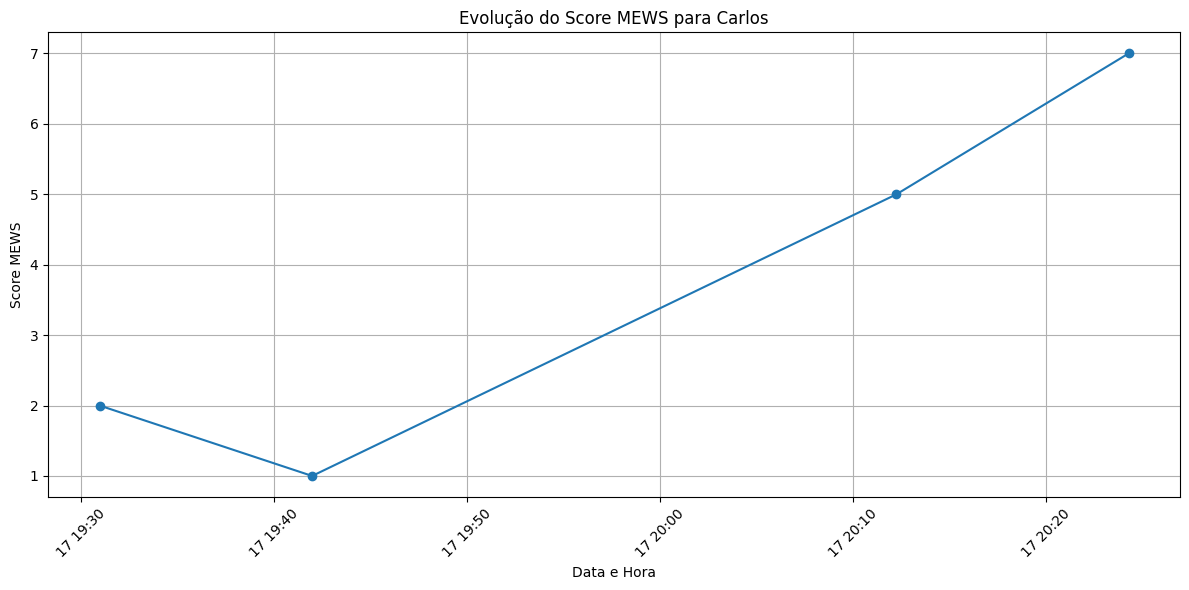

Debug: Gráfico plotado (mais de 1 ponto no FILTRADO).

Para ver as observações e a análise da IA de cada ponto do gráfico, consulte a Tabela de Histórico acima (apenas para Carlos).


In [ ]:
# --- 11. Fluxo Principal do Programa ---
#display(to_markdown(interpretation_formatted))
def main():
    print(f"--- Sistema MEWS com Registro no Google Drive e Suporte de IA ---")
    print(f"⚠️ Lembre-se: A análise da IA é um suporte e NÃO substitui o julgamento clínico. ⚠️")

    # Esta função é chamada UMA VEZ no início para carregar o histórico COMPLETO
    df_history = load_or_create_excel(excel_path)

    while True:
        print(f"\n--- Nova Monitorização ---")
        # PERGUNTA O ID/NOME DO PACIENTE NO INÍCIO DE CADA MONITORIZAÇÃO
        patient_id = input("Digite o ID ou Nome do Paciente (ou deixe em branco): ") or "Paciente Não Identificado"
        # Garantir que o ID do paciente é uma string e remover espaços extras
        patient_id = str(patient_id).strip()
        if patient_id == "":
             patient_id = "Paciente Não Identificado" # Garante que não fica vazio


        try:
            fr_input = input("Digite a Frequência Respiratória (ou 'não informado'): ")
            fr = int(fr_input) if fr_input.strip().lower() != 'não informado' else 'Não informado'

            temp_input = input("Digite a Temperatura (ex: 36.5 ou 'não informado'): ")
            temp = float(temp_input) if temp_input.strip().lower() != 'não informado' else 'Não informado'

            pa_input = input("Digite a Pressão Arterial Sistólica (ex: 120 ou 'não informado'): ")
            pa = int(pa_input) if pa_input.strip().lower() != 'não informado' else 'Não informado'

            fc_input = input("Digite a Frequência Cardíaca (ou 'não informado'): ")
            fc = int(fc_input) if fc_input.strip().lower() != 'não informado' else 'Não informado'

            nc_input = input("Digite o Nível de Consciência (Alerta, V (Resposta a estímulo verbal), P (Resposta a estímulo de dor), U (Sem resposta a estímulo) ou 'não informado'): ")
            nc = nc_input.strip()

            observations = input("Digite as Observações relevantes: ")

            vital_signs_input_str = f"FR: {fr}, Temperatura: {temp}, PA Sistólica: {pa}, FC: {fc}, Nível de Consciência: {nc}"

        except ValueError as e:
            print(f"Entrada inválida: Por favor, digite números ou 'não informado' para os sinais vitais. Erro: {e}")
            continue

        print("\n" + "="*40)

        mews_score = calculate_mews_score(fr, temp, pa, fc, nc)
        interpretation_raw = interpret_mews_score_with_gemini(mews_score, vital_signs_input_str, "Protocolo institucional")
        interpretation_formatted = interpretation_raw

        print(f"--- Resultado MEWS ---")
        #print(interpretation_formatted)
        display(to_markdown(interpretation_formatted))

        analyzed_obs_raw = analyze_observations_with_gemini(observations)
        print(f"\n--- Análise de Observações (IA) ---")
        #print(analyzed_obs_raw)
        display(to_markdown(analyzed_obs_raw))


        print("="*40 + "\n")

        # --- Salvar Dados ---
        # Passa o patient_id correto para a função de salvar
        df_history = add_data_and_save(df_history, patient_id, fr, temp, pa, fc, nc, observations, mews_score, analyzed_obs_raw, excel_path)


        # --- Exibir Histórico ---
        # PASSA O patient_id PARA A FUNÇÃO DE EXIBIÇÃO
        display_history(df_history, patient_id)

        novo_paciente = input(f"\nDeseja adicionar uma nova monitorização? (s/n): ").lower()
        if novo_paciente != 's':
            break

    print(f"\nSistema encerrado. Os dados e análises da IA estão salvos no Google Drive.")


# --- Executar o Programa Principal ---
if __name__ == "__main__":
    main()